In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import cv2
import seaborn as sns 


input_data_path = "D:/face_mask/images"
annotations_path = "D:/face_mask/annotations"
images = [*os.listdir(input_data_path)]
output_data_path =  '.'

In [4]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result

def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [5]:
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

In [6]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss0,512,366,3,without_mask,79,105,109,142
1,maksssksksss0,512,366,3,with_mask,185,100,226,144
2,maksssksksss0,512,366,3,without_mask,325,90,360,141
3,maksssksksss1,400,156,3,with_mask,321,34,354,69
4,maksssksksss1,400,156,3,with_mask,224,38,261,73


In [7]:
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df["file"] == final_test_image]
images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

In [8]:
df

,file,width,height,depth,name,xmin,ymin,xmax,ymax
3,maksssksksss1,400,156,3,with_mask,321,34,354,69
4,maksssksksss1,400,156,3,with_mask,224,38,261,73
5,maksssksksss1,400,156,3,with_mask,299,58,315,81
6,maksssksksss1,400,156,3,with_mask,143,74,174,115
7,maksssksksss1,400,156,3,with_mask,74,69,95,99
...,...,...,...,...,...,...,...,...,...
4067,maksssksksss98,400,267,3,with_mask,263,62,287,85
4068,maksssksksss98,400,267,3,with_mask,344,80,377,106
4069,maksssksksss99,400,267,3,mask_weared_incorrect,181,54,273,162
4070,maksssksksss99,400,267,3,with_mask,99,87,176,165


In [9]:
df["name"].value_counts()

name
with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: count, dtype: int64

Text(0, 0.5, 'name')

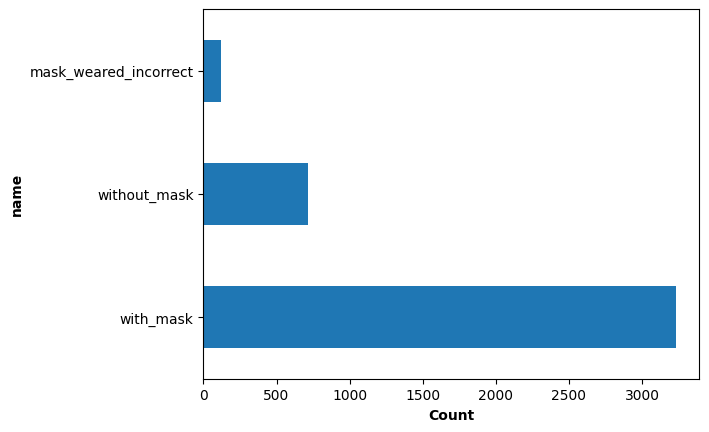

In [10]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('name', fontsize = 10, fontweight = 'bold')

In [11]:
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [12]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [13]:
def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [14]:
cropped_faces = [extract_faces(img, df) for img in images]

In [15]:
flat_cropped_faces = sum(cropped_faces, [])

In [16]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [17]:
print(len(with_mask))
print(len(without_mask))
print(len(mask_weared_incorrect))
print(len(with_mask) + len(without_mask) + len(mask_weared_incorrect))

3231
715
123
4069


In [18]:
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [19]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)

In [20]:
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
        
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

In [21]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()

C:\Users\mrroy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 35, 35, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 17, 17, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 17, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         512,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537,587 (2.05 MB)

 Trainable params: 537,587 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
batch_size = 8
epochs = 50

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory=r"D:\face_mask\train", 
    target_size=(35, 35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory=r"D:\face_mask\val", 
    target_size=(35, 35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory=r"D:\face_mask\test", 
    target_size=(35, 35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [23]:
data_size = len(train_generator)

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [24]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [26]:
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)


In [27]:
model_history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)


Epoch 1/50


C:\Users\mrroy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.8826 - Precision: 0.7886 - Recall: 0.6885 - accuracy: 0.7476 - loss: 0.6778 - val_AUC: 0.9324 - val_Precision: 0.7500 - val_Recall: 0.7500 - val_accuracy: 0.7500 - val_loss: 0.5342 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.9488 - Precision: 0.8415 - Recall: 0.8319 - accuracy: 0.8414 - loss: 0.4414 - val_AUC: 0.9538 - val_Precision: 0.8714 - val_Recall: 0.8472 - val_accuracy: 0.8750 - val_loss: 0.4332 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.9727 - Precision: 0.9116 - Recall: 0.8945 - accuracy: 0.8987 - loss: 0.3138 - val_AUC: 0.9891 - val_Precision: 0.9571 - val_Recall: 0.9306 - val_accuracy: 0.9444 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.9746 - Precision: 0.9315 - Recall: 0.9090 - accuracy: 0.9301 - loss: 0.2879 - val_AUC: 0.9718 - val_Precision: 0.9286 - val_Recall: 0.9028 - val_accuracy: 0

C:\Users\mrroy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.9759 - Precision: 0.9280 - Recall: 0.9192 - accuracy: 0.9211 - loss: 0.2685 - val_AUC: 0.9848 - val_Precision: 0.9155 - val_Recall: 0.9028 - val_accuracy: 0.9167 - val_loss: 0.2246 - learning_rate: 0.0010
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.9773 - Precision: 0.9243 - Recall: 0.9171 - accuracy: 0.9205 - loss: 0.2609 - val_AUC: 0.9831 - val_Precision: 0.9306 - val_Recall: 0.9306 - val_accuracy: 0.9306 - val_loss: 0.2090 - learning_rate: 0.0010
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.9867 - Precision: 0.9588 - Recall: 0.9560 - accuracy: 0.9589 - loss: 0.1856 - val_AUC: 0.9743 - val_Precision: 0.9296 - val_Recall: 0.9167 - val_accuracy: 0.9306 - val_loss: 0.2715 - learning_rate: 0.0010
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.9670 - Precision: 0.9291 - Recall: 0.9117 - accuracy: 0.9236 - loss: 0.3063 - val_AUC: 0.9806 - val_Precision: 0.9028 - val_Recall: 0.9028 - val_accuracy

In [28]:
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print(f'{model_loss} || {model_acc*100} || {recall*100} || {precision*100} || {auc*100}')

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9706 - Precision: 0.8568 - Recall: 0.8493 - accuracy: 0.8580 - loss: 0.3075 
0.1833595186471939 || 93.41563582420349 || 93.00411343574524 || 93.388432264328 || 99.03512597084045


In [29]:
predictions = model.predict(test_generator)
predictions

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


array([[2.70360470e-01, 7.29200125e-01, 4.39443189e-04],
       [5.97151108e-02, 9.09915447e-01, 3.03693824e-02],
       [1.69511527e-01, 8.10678303e-01, 1.98101848e-02],
       [1.58892080e-01, 8.39127660e-01, 1.98024744e-03],
       [2.74880946e-01, 7.22086489e-01, 3.03256139e-03],
       [4.87067431e-01, 5.05506158e-01, 7.42642768e-03],
       [4.59048189e-02, 9.06950891e-01, 4.71443497e-02],
       [6.83989783e-04, 9.99315977e-01, 7.72659732e-08],
       [2.26050653e-02, 9.76868033e-01, 5.26906573e-04],
       [1.31462060e-03, 9.98573303e-01, 1.12056841e-04],
       [8.73711333e-03, 9.90509033e-01, 7.53824832e-04],
       [1.90990439e-04, 9.99808848e-01, 2.35592495e-07],
       [1.09425886e-03, 9.98889148e-01, 1.65756865e-05],
       [2.27321405e-03, 9.97724473e-01, 2.36181040e-06],
       [1.03654759e-02, 9.89027262e-01, 6.07253052e-04],
       [7.46193182e-05, 9.99925375e-01, 4.41549695e-08],
       [2.55510695e-02, 9.52852249e-01, 2.15967577e-02],
       [1.01042101e-02, 9.88438

In [30]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

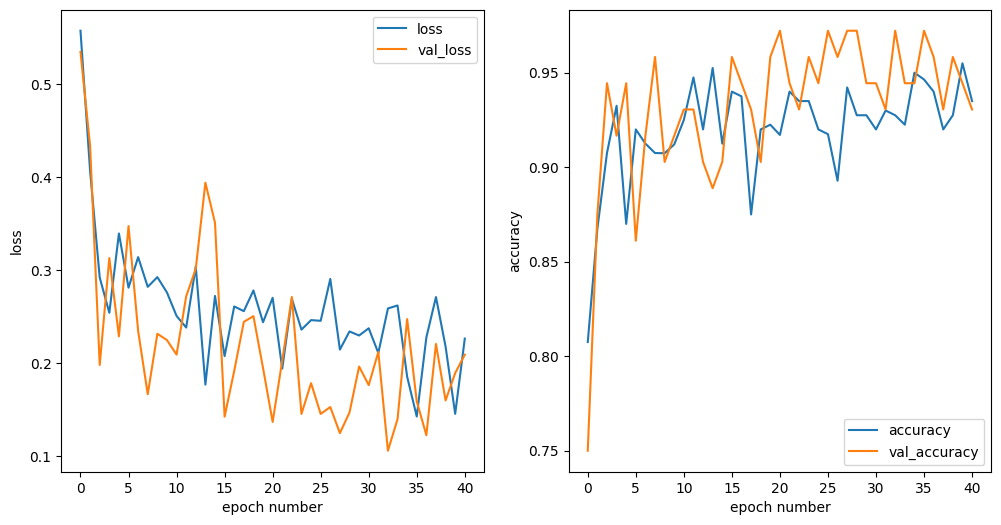

In [31]:
plot_loss_and_accuracy(model_history.history)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
with_mask || with_mask\maksssksksss647_(np.int64(368), np.int64(58)).png


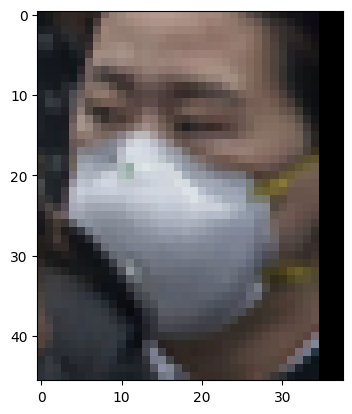

In [32]:
paths = test_generator.filenames
y_pred = model.predict(test_generator).argmax(axis=1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

In [33]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


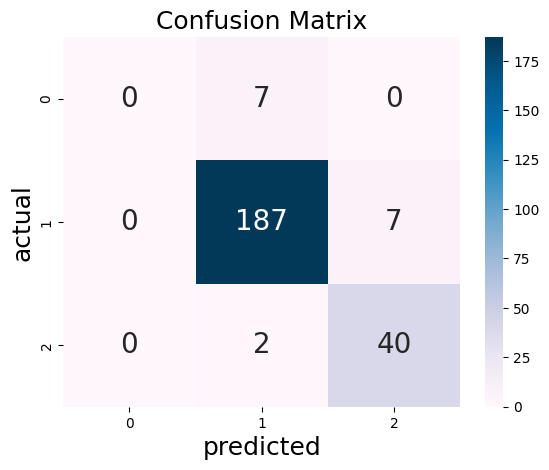

In [34]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)


In [35]:
display(classes)
np.bincount(y_pred)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

array([  0, 196,  47])

In [36]:
def predict_single_image(model, image_path, class_indices, target_size=(35, 35)):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")  # Ensure 3 channels
    img = img.resize(target_size)  # Resize image
    img_array = np.array(img) / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}  # Reverse class_indices
    predicted_label = class_labels[predicted_class]

    # Display result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

    print(f"Prediction Probabilities: {prediction[0]}")
    print(f"Predicted Class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


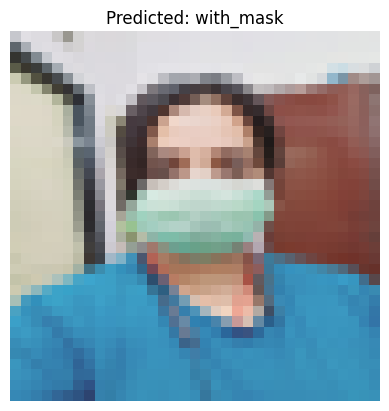

Prediction Probabilities: [0.44255704 0.51653975 0.04090312]
Predicted Class: with_mask


In [38]:
# Path to your single image
image_path = r"K:\pics\IMG-20241217-WA0014.jpg"

# Predict the result
predict_single_image(model, image_path, test_generator.class_indices)
